# Imports

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

# Load the dataset

In [18]:
# Load dataset (local)
#dataset_zip = np.load('../dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', encoding='bytes')

# Load dataset (Kaggle)
dataset_zip = np.load('/kaggle/input/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', encoding='bytes')

In [3]:
# create a class dSpritesDataset -> DataLoader
class dSpritesDataset(Dataset):
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        if self.transform:
            img = Image.fromarray(img)
            img = self.transform(img)
        return img
    
class RescaleBinaryImage:
    def __call__(self, tensor):
        return tensor / tensor.max()

transform = transforms.Compose([
    transforms.ToTensor(),
    RescaleBinaryImage()
])

imgs = dataset_zip['imgs']
dsprites = dSpritesDataset(imgs, transform=transform)

subset_size = 15000
dsprites_small = random_split(dsprites, [subset_size, len(imgs)-subset_size])[0]
imgs_train, imgs_test = random_split(dsprites_small, [0.8, 0.2])

batch_size = 64
imgs_trainloader = DataLoader(imgs_train, batch_size=batch_size, shuffle=False)
imgs_testloader = DataLoader(imgs_test, batch_size=batch_size, shuffle=False)

# Some visualizations

In [4]:
img = next(iter(imgs_trainloader))
img.shape

torch.Size([64, 1, 64, 64])

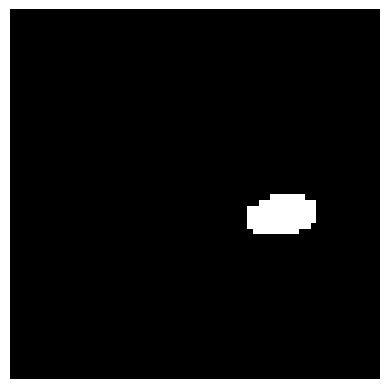

In [5]:
# view images from dataloader

plt.imshow(img[0].permute(1,2,0), cmap='gray', vmin=img[0].min().item(), vmax=img[0].max().item())
plt.axis('off')
plt.show()

# The Beta-VAE architecture

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim=64, z_dim=10, h_dim1=32, h_dim2=64, fc_dim=128, n_channels=1, kernel_size=4, stride=2):
        super(Encoder, self).__init__()

        self.input_dim = input_dim
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.h_dim1 = h_dim1
        self.h_dim2 = h_dim2
        self.z_dim = z_dim
        self.fc_dim = fc_dim
        
        self.output_size = 2

        self.conv1 = nn.Conv2d(self.n_channels, self.h_dim1, kernel_size=self.kernel_size, stride=self.stride)
        self.conv2 = nn.Conv2d(self.h_dim1, self.h_dim1, kernel_size=self.kernel_size, stride=self.stride)
        self.conv3 = nn.Conv2d(self.h_dim1, self.h_dim2, kernel_size=self.kernel_size, stride=self.stride)
        self.conv4 = nn.Conv2d(self.h_dim2, self.h_dim2, kernel_size=self.kernel_size, stride=self.stride)
        
        self.fc = nn.Linear(self.output_size * self.output_size * self.h_dim2, self.fc_dim)
        self.fc_mu = nn.Linear(self.fc_dim, self.z_dim)
        self.fc_logvar = nn.Linear(self.fc_dim, self.z_dim)

    def forward(self, x):
        out = F.relu(self.conv1(x))  # [64, 32, 31, 31]
        out = F.relu(self.conv2(out)) # [64, 32, 14, 14]
        out = F.relu(self.conv3(out)) # [64, 64, 6, 6]
        out = F.relu(self.conv4(out)) # [64, 64, 2, 2]
        
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, input_dim=64, z_dim=10, h_dim=32, h_dim2=64, fc_dim=128, n_channels=1, kernel_size=4, stride=2):
        super(Decoder, self).__init__()

        self.input_dim = input_dim
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.h_dim = h_dim
        self.h_dim2 = h_dim2
        self.z_dim = z_dim
        self.fc_dim = fc_dim

        self.fc1 = nn.Linear(self.z_dim, self.fc_dim)   # [64, 128]
        self.fc2 = nn.Linear(self.fc_dim, self.kernel_size * self.kernel_size * self.h_dim2)   # [64, 4 x 4 x 64] -> [64, 64, 4, 4]
        
        self.conv1 = nn.ConvTranspose2d(self.h_dim2, self.h_dim2, kernel_size=kernel_size, stride=stride, padding=1)    # [64, 64, 8, 8]
        self.conv2 = nn.ConvTranspose2d(self.h_dim2, self.h_dim, kernel_size=kernel_size, stride=stride, padding=1)     # [64, 32, 16, 16]
        self.conv3 = nn.ConvTranspose2d(self.h_dim, self.h_dim, kernel_size=kernel_size, stride=stride, padding=1)      # [64, 32, 32, 32]
        self.conv4 = nn.ConvTranspose2d(self.h_dim, self.n_channels, kernel_size=kernel_size, stride=stride, padding=1) # [64, 1, 64, 64]

    def forward(self, z):
        out = F.relu(self.fc1(z))
        out = F.relu(self.fc2(out))
        out = out.reshape(out.shape[0], self.h_dim2, self.kernel_size, self.kernel_size)
        out = F.relu(self.conv1(out))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        y = torch.sigmoid(self.conv4(out))  # to ensure the image has values between 0 and 1
        return y


class BetaVAE(nn.Module):
    def __init__(self, beta):
        super(BetaVAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.beta = beta

    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var

    def loss_function(self, x_recon, x, mu, log_var):
        BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')  # the output has sigmoid, so we use basic BCE
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + self.beta * KLD

# The training pipeline

========================EPOCH n°1========================
====> Epoch: 1 Average loss: 1324.7551
====> Test set loss: 666.0864
========================EPOCH n°2========================
====> Epoch: 2 Average loss: 614.5288
====> Test set loss: 583.3581
========================EPOCH n°3========================
====> Epoch: 3 Average loss: 563.4005
====> Test set loss: 475.1454
========================EPOCH n°4========================
====> Epoch: 4 Average loss: 316.6392
====> Test set loss: 257.7287
========================EPOCH n°5========================
====> Epoch: 5 Average loss: 242.0725
====> Test set loss: 227.7053
========================EPOCH n°6========================
====> Epoch: 6 Average loss: 195.5227
====> Test set loss: 153.5029
========================EPOCH n°7========================
====> Epoch: 7 Average loss: 143.7571
====> Test set loss: 138.4835
========================EPOCH n°8========================
====> Epoch: 8 Average loss: 136.3665
====> Test set loss: 

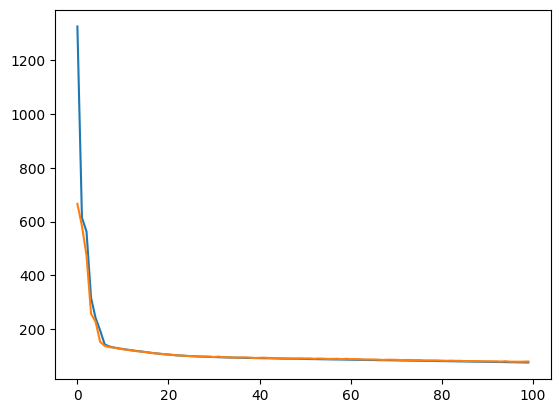

In [43]:
# Hyperparameters
beta = 1
learning_rate = 1e-4

# training phase
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BetaVAE(beta).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

epochs = 100
train_losses = []
test_losses = []

for epoch in range(epochs):
    print(f"========================EPOCH n°{epoch+1}========================")
    model.train()
    train_loss = 0
    for i, data in enumerate(imgs_trainloader):
        optimizer.zero_grad()
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        loss = model.loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch+1, train_loss / len(imgs_trainloader.dataset)))
    train_losses.append(train_loss / len(imgs_trainloader.dataset))

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(imgs_testloader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += model.loss_function(recon_batch, data, mu, logvar).item()
    test_loss /= len(imgs_testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    test_losses.append(test_loss)

plt.plot(train_losses)
plt.plot(test_losses)

# Save/Load model (if needed)

In [44]:
# # Save the model if needed
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             }, 'betaVAE_{}_epochs.pt'.format(epoch))

In [9]:
# #Load the model if needed
# model = BetaVAE(beta).to(device)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# checkpoint = torch.load('betaVAE_{}_epochs.pt'.format(epoch))
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']

# Compare the reconstructions with the original data

In [45]:
def plot_reconstructions(model, data_loader, device, n=10):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            data = data.cpu()
            recon_batch = recon_batch.cpu()
            for i in range(n):
                plt.subplot(2, n, i + 1)
                plt.imshow(data[i].permute(1,2,0), cmap='gray')
                plt.axis('off')
                plt.subplot(2, n, i + 1 + n)
                plt.imshow(recon_batch[i].permute(1,2,0), cmap='gray')
                plt.axis('off')
            plt.show()

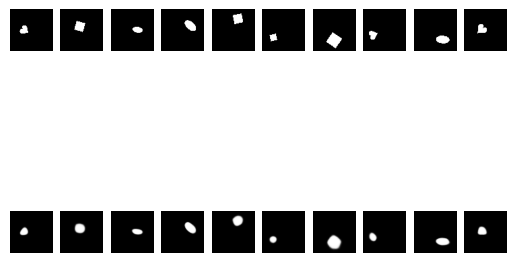

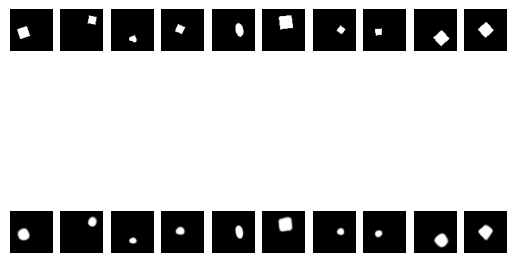

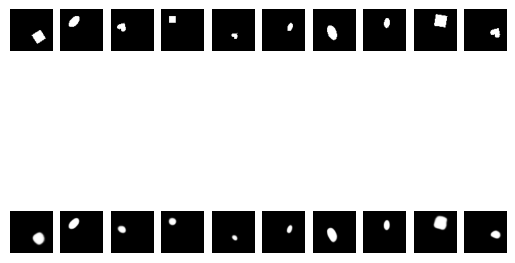

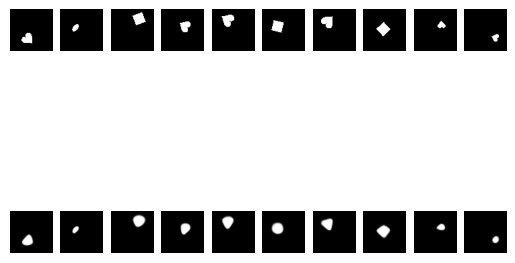

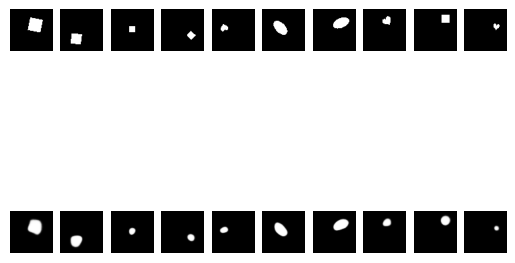

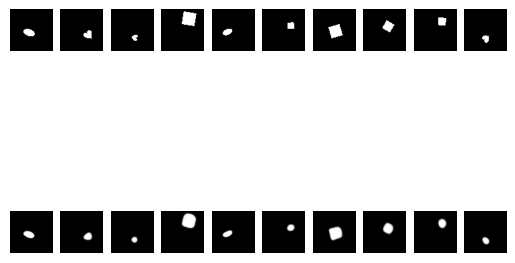

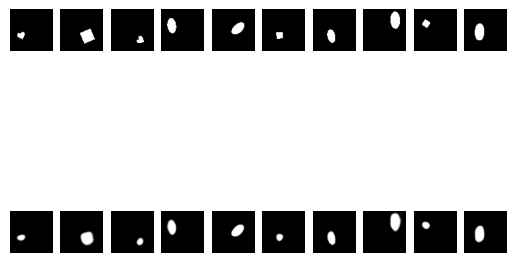

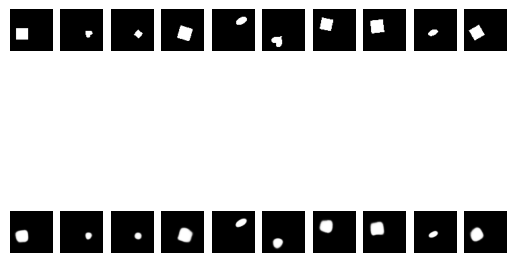

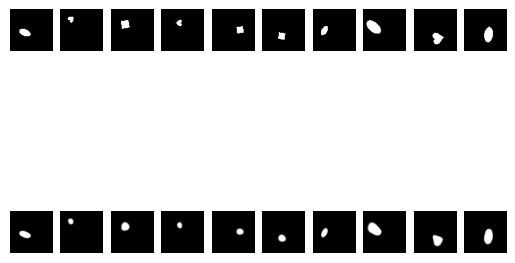

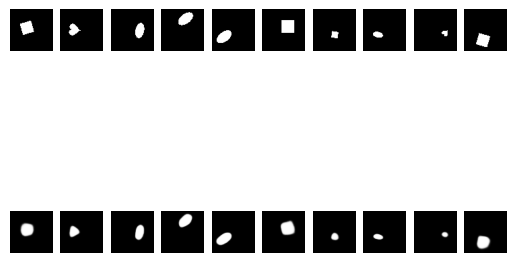

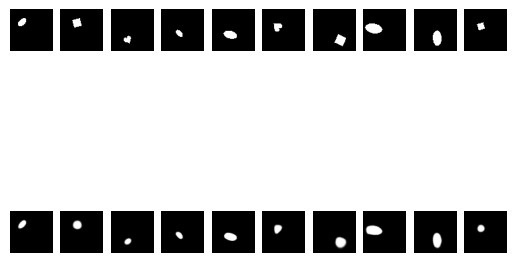

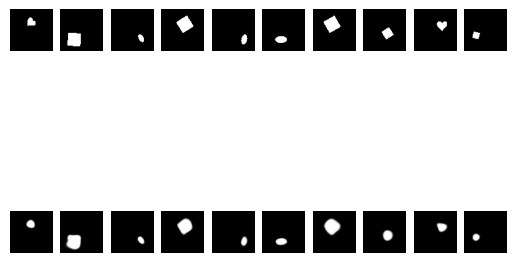

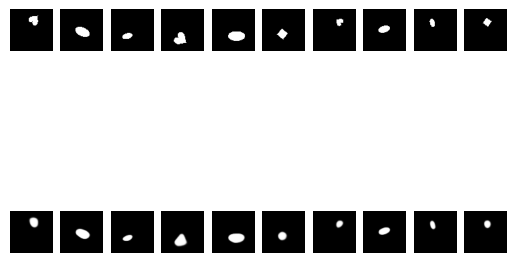

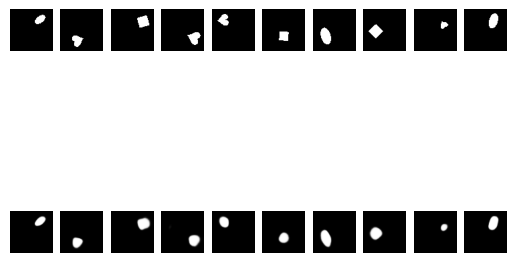

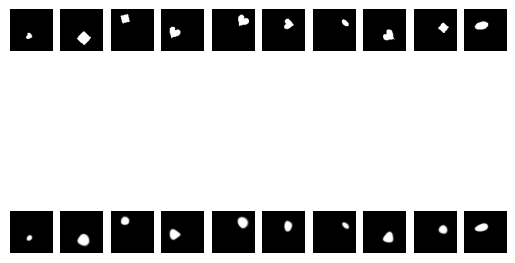

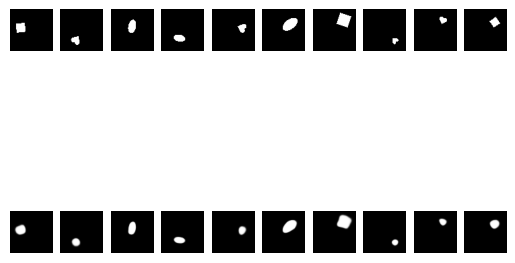

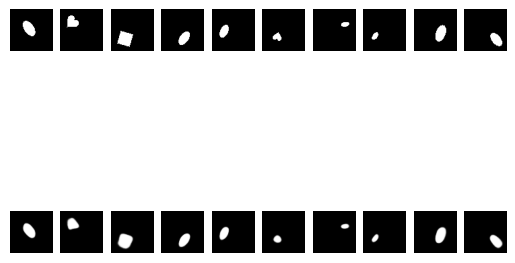

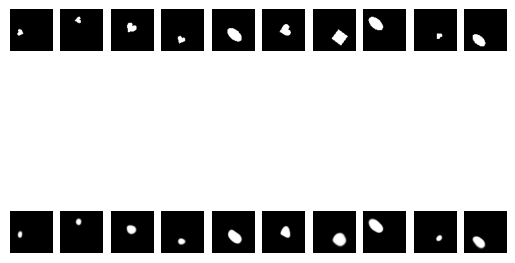

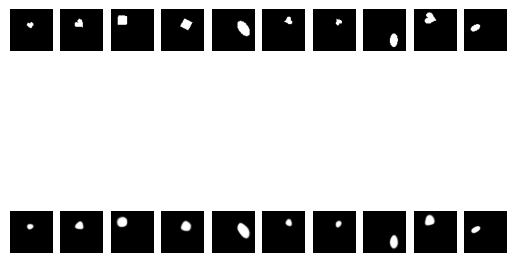

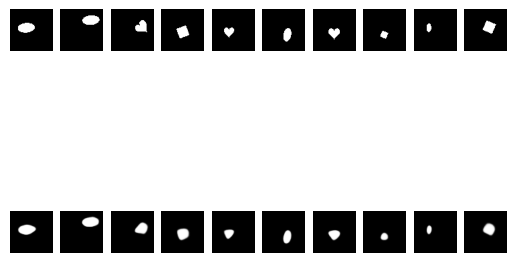

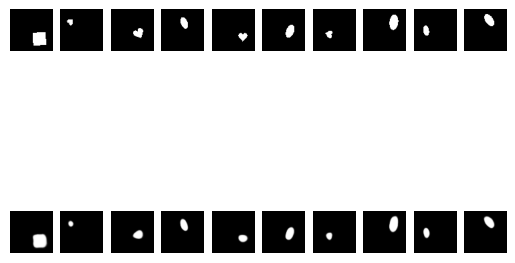

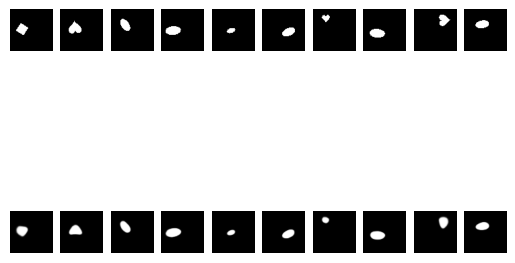

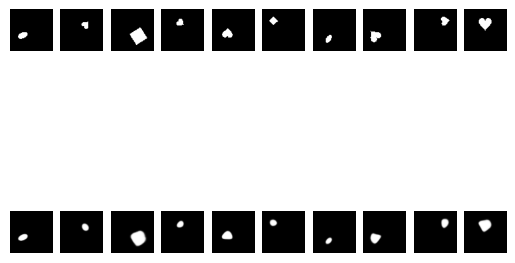

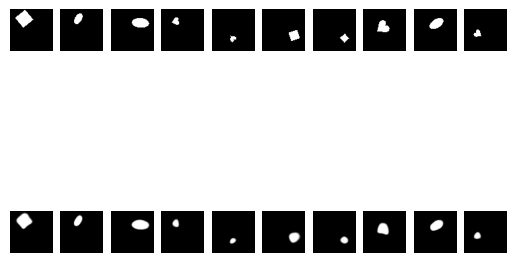

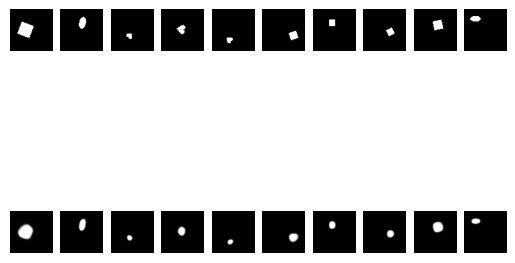

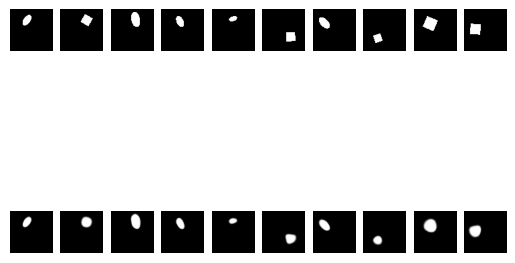

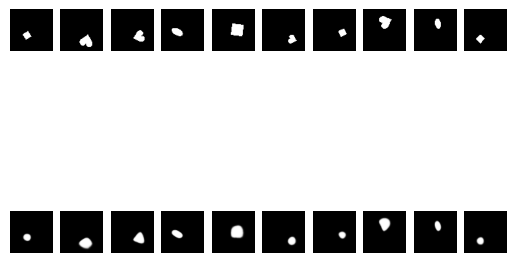

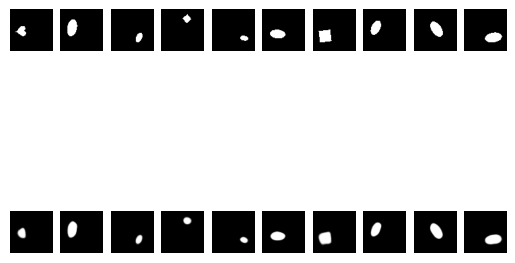

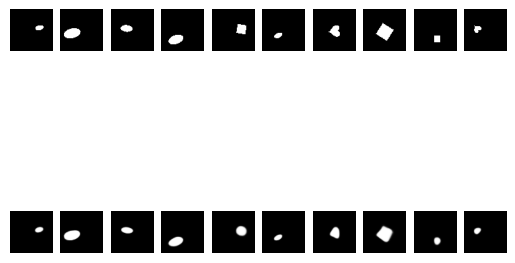

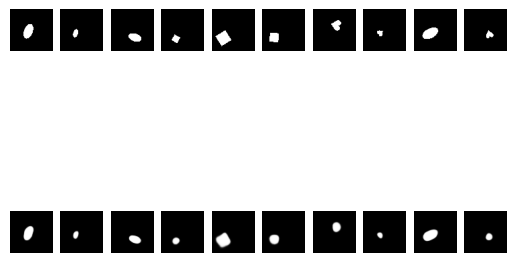

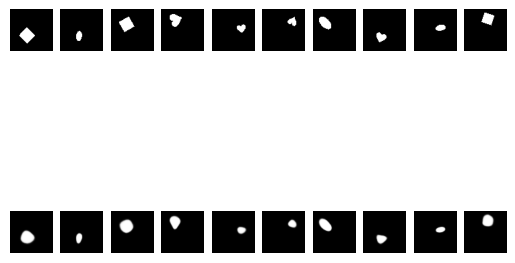

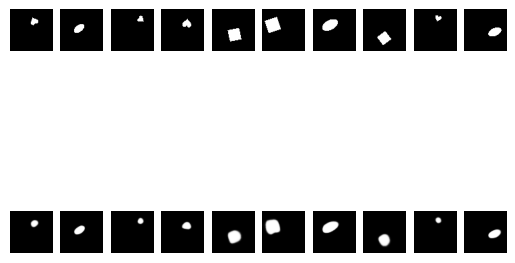

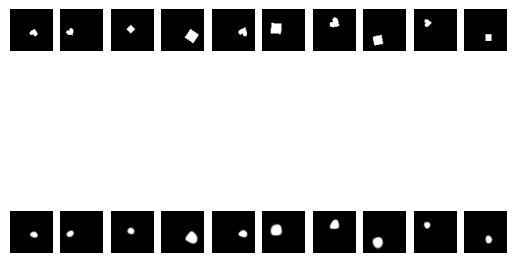

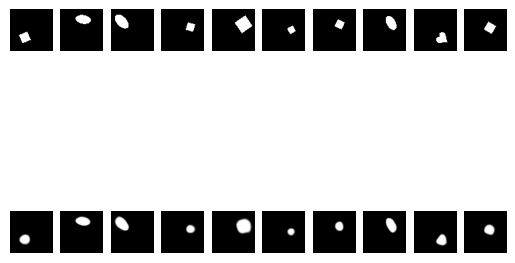

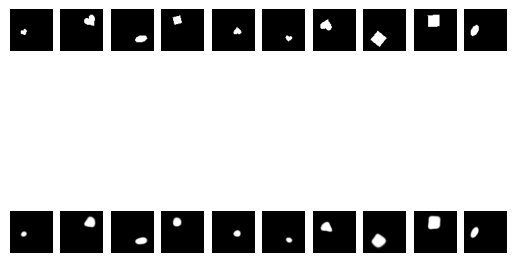

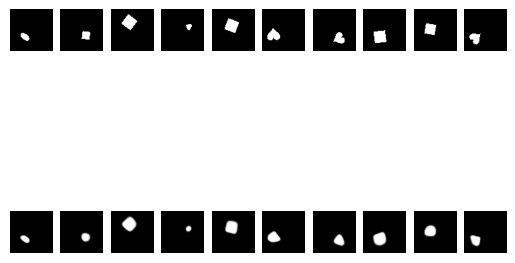

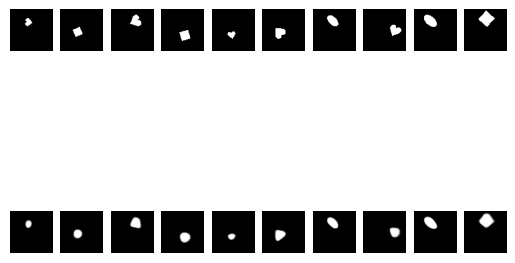

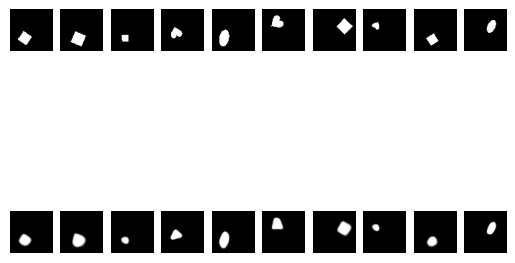

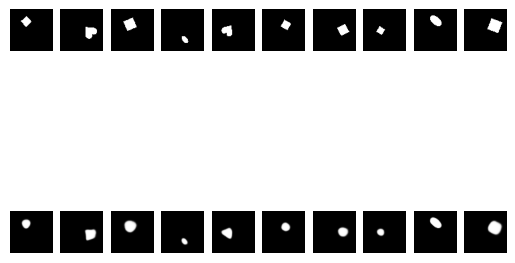

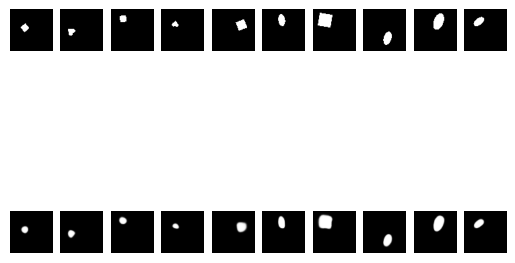

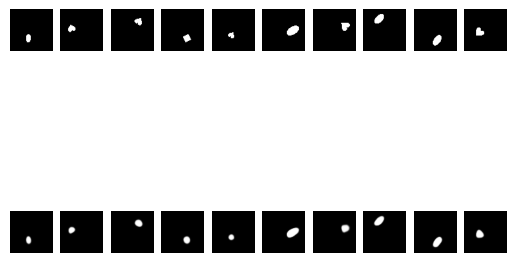

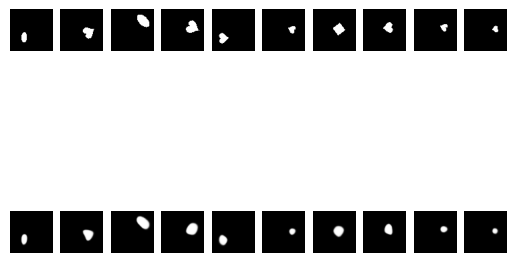

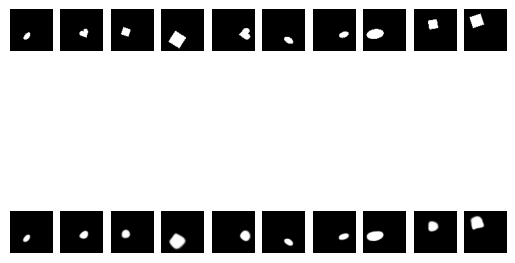

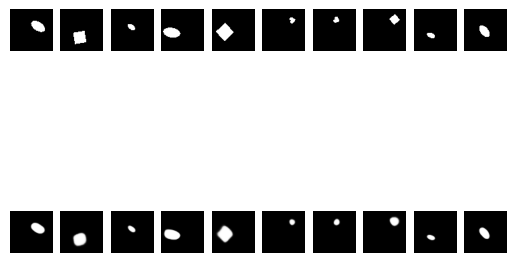

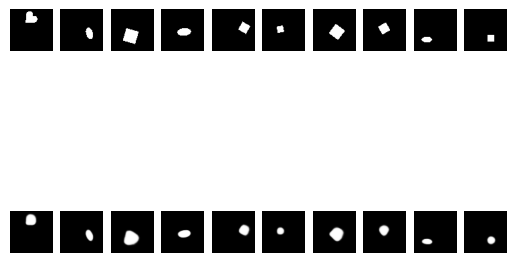

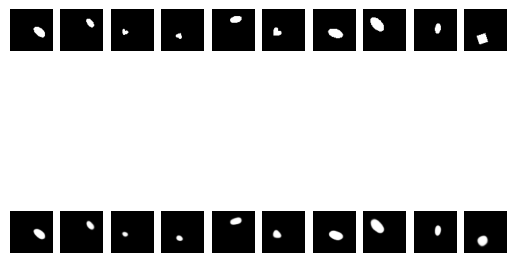

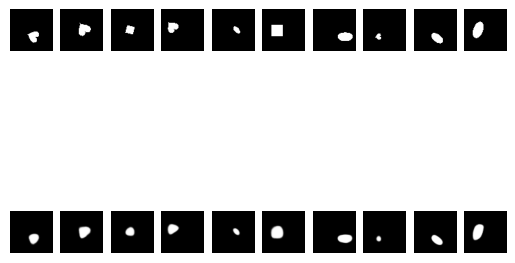

In [46]:
plot_reconstructions(model, imgs_testloader, device)

In [49]:
def plot_latent_traversals_each_dim(model, device, n=10, z_dim=10, traversal_range=3):
    """
    Visualize latent traversals along each dimension of the latent space.
    
    Args:
    - model (nn.Module): Trained VAE model.
    - device (torch.device): Device to perform computations on (cuda or cpu).
    - n (int): Number of samples to generate for each traversal.
    - z_dim (int): Dimension of the latent space.
    - traversal_range (float): Range for latent traversal.
    
    Returns:
    - None: Displays the grid of generated images for each dimension.
    """
    model.eval()
    with torch.no_grad():
        # Generate fixed latent codes
        fixed_z = torch.randn(n, z_dim).to(device)
        
        # Create traversal values
        traversal_values = torch.linspace(-traversal_range, traversal_range, n).to(device)
        
        # Loop over each dimension and create traversed latent codes
        for fixed_dim in range(z_dim):
            latent_codes = fixed_z.clone()
            for i in range(n):
                latent_codes[i, fixed_dim] = traversal_values[i]
            
            # Generate images from traversed latent codes
            reconstructions = model.decoder(latent_codes)
            
            # Plotting
            plt.figure(figsize=(n, 2))
            for i in range(n):
                plt.subplot(2, n, i + 1)
                plt.imshow(reconstructions[i].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
                plt.axis('off')
            plt.suptitle(f'Latent Dimension {fixed_dim+1}')
            plt.show()


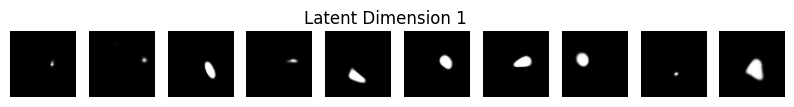

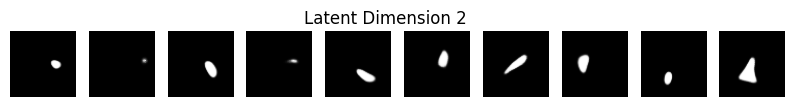

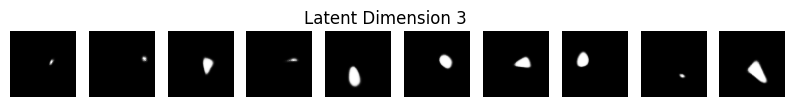

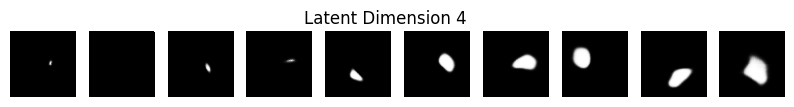

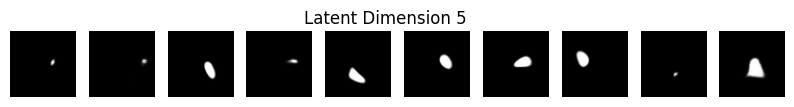

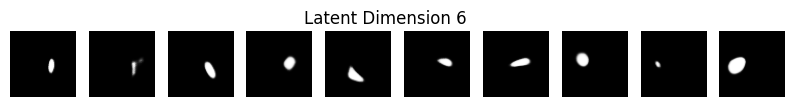

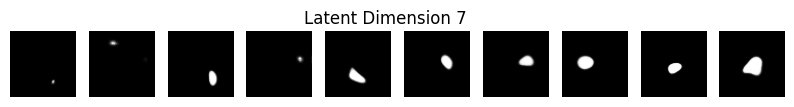

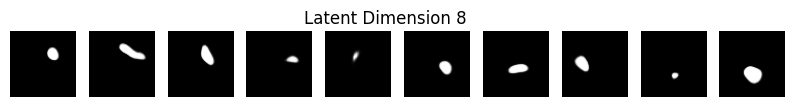

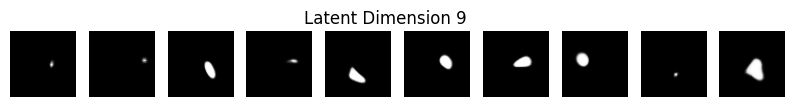

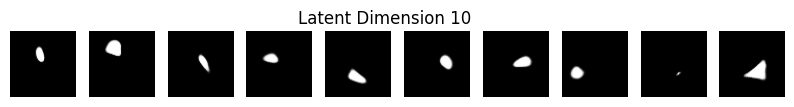

In [50]:
n = 10  # Number of samples for each traversal
traversal_range = 3  # Range for traversal

plot_latent_traversals_each_dim(model, device, n=n, z_dim=10, traversal_range=traversal_range)

In [12]:
latent_values = dataset_zip['latents_values']
latent_classes = dataset_zip['latents_classes']

In [14]:
latent_classes.shape

(737280, 6)

# Disentanglement metric score for the BetaVAE

In [58]:
L = 20
B = 32
K = 6



z_vec = []
labels = []
# We construct a batch of B vectors :
for b in range(B):
    z_batch = []
    
    # Choose a factor y uniformly at random between the 6 ones
    y = np.random.randint(0, K)
    labels.append(y)
    for l in range(L):
        # Sample two sets of latent representations
        v_1l = np.array([np.random.choice(np.unique(latent_classes[:,i])) for i in range(K)])
        v_2l = np.array([np.random.choice(np.unique(latent_classes[:,i])) for i in range(K)])
        
        # Enforce v_1l[y] == v_2l[y]
        v_1l[y] = v_2l[y]

        idx_1 = np.where((latent_classes == v_1l).all(axis=1))[0]
        idx_2 = np.where((latent_classes == v_2l).all(axis=1))[0]

        imgs_1 = imgs[idx_1][0]
        imgs_2 = imgs[idx_2][0]
        
        model.eval()

        z_1, _ = model.encoder(torch.tensor(imgs_1, dtype=torch.float).view(1, 1, 64, 64).to(device))
        z_2, _ = model.encoder(torch.tensor(imgs_2, dtype=torch.float).view(1, 1, 64, 64).to(device))
        z_1 = z_1.cpu().detach()
        z_2 = z_2.cpu().detach()
        z_diff = torch.abs(z_1 - z_2)
        z_batch.append(z_diff)
    z_batch_t = torch.tensor(np.array(z_batch), dtype=torch.float)
    z_b_mean = torch.mean(z_batch_t, dim=0)
    z_vec.append(z_b_mean)

z_vec_tensor = torch.tensor(np.array(z_vec), dtype=torch.float).squeeze(1)
labels_tensor = torch.tensor(np.array(labels), dtype=torch.long)

In [63]:
z_vec_tensor

tensor([[0.2744, 1.0181, 1.1747, 1.1676, 0.9717, 0.9097, 0.6118, 0.6123, 0.1840,
         1.2779],
        [0.3646, 1.1253, 0.9377, 1.3704, 0.8099, 1.3046, 1.1480, 1.7916, 0.1964,
         1.1350],
        [0.3283, 1.0215, 1.2488, 0.9671, 0.9833, 1.3169, 0.7362, 0.8179, 0.2325,
         1.2403],
        [0.3184, 1.3166, 1.0958, 0.9719, 1.2709, 1.2399, 1.1525, 1.6338, 0.2455,
         1.3084],
        [0.2128, 1.5390, 0.9162, 0.9702, 0.6570, 1.3242, 1.0208, 1.4445, 0.2150,
         1.5082],
        [0.2567, 1.1561, 0.7820, 0.9708, 1.2366, 0.5262, 1.0731, 1.2049, 0.2160,
         1.3661],
        [0.2504, 1.1687, 0.7966, 0.9753, 0.8132, 1.5214, 1.2598, 1.2838, 0.2173,
         1.2231],
        [0.3777, 1.2638, 0.8799, 1.2064, 0.9285, 1.2613, 1.1049, 1.2764, 0.2312,
         1.4052],
        [0.2828, 1.2831, 0.8189, 0.6365, 0.7343, 1.0948, 1.0811, 1.1886, 0.2171,
         1.1839],
        [0.2323, 1.2245, 1.0629, 0.7301, 0.7887, 1.1606, 1.1618, 1.4750, 0.2064,
         1.6547],
        [0

In [64]:
labels_tensor

tensor([5, 0, 5, 0, 1, 4, 1, 0, 2, 2, 0, 3, 3, 3, 1, 2, 0, 4, 3, 1, 4, 2, 1, 4,
        5, 5, 1, 2, 2, 3, 4, 4])

In [82]:
dataset = TensorDataset(z_vec_tensor, labels_tensor)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [91]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return F.log_softmax(self.fc(x), dim=1)
    
# Hyperparameters
input_dim = 10
output_dim = 6
learning_rate = 1e-2

# training phase
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = LinearClassifier(input_dim, output_dim).to(device)
optimizer = optim.Adagrad(classifier.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

epochs = 200
train_losses = []
test_losses = []

disentanglement_score = 0

for epoch in range(epochs):
    classifier.train()
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = classifier(inputs)
        _, predicted_indices = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Print training loss for each epoch
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 3. Evaluate the accuracy of the trained classifier
classifier.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = classifier(inputs)
        _, predicted_indices = torch.max(outputs, 1)
        print("Predictions :", predicted_indices)
        print("Labels :", labels)
        correct += (predicted_indices == labels).sum().item()
        total += labels.size(0)
    
    disentanglement_score = 100 * correct / total
    print('Disentanglement metric score: %d %%' % (disentanglement_score))

Epoch [10/200], Loss: 1.4962
Epoch [20/200], Loss: 1.7459
Epoch [30/200], Loss: 1.4925
Epoch [40/200], Loss: 2.0087
Epoch [50/200], Loss: 2.3367
Epoch [60/200], Loss: 1.7830
Epoch [70/200], Loss: 1.7542
Epoch [80/200], Loss: 1.2779
Epoch [90/200], Loss: 2.0761
Epoch [100/200], Loss: 1.3949
Epoch [110/200], Loss: 1.3617
Epoch [120/200], Loss: 2.4877
Epoch [130/200], Loss: 1.6783
Epoch [140/200], Loss: 1.2650
Epoch [150/200], Loss: 1.3738
Epoch [160/200], Loss: 1.6523
Epoch [170/200], Loss: 1.7494
Epoch [180/200], Loss: 1.7424
Epoch [190/200], Loss: 2.3666
Epoch [200/200], Loss: 2.3642
Predictions : tensor([1, 1], device='cuda:0')
Labels : tensor([0, 3], device='cuda:0')
Predictions : tensor([1, 4], device='cuda:0')
Labels : tensor([5, 3], device='cuda:0')
Predictions : tensor([1, 1], device='cuda:0')
Labels : tensor([2, 2], device='cuda:0')
Predictions : tensor([1], device='cuda:0')
Labels : tensor([3], device='cuda:0')
Disentanglement metric score: 0 %
